In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os
import holidays
from statsmodels.tsa.stattools import adfuller


In [ ]:
# === 1. Чтение данных ===
df_weather = pd.read_csv('../data/weather.csv')
df_key = pd.read_csv('../data/key.csv')
df_train = pd.read_csv('../data/train.csv')
df_store_city_coordinates = pd.read_csv('../data/store_city_coordinates.csv')
df_test = pd.read_csv('../data/test.csv')


In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617600 entries, 0 to 4617599
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   date       object
 1   store_nbr  int64 
 2   item_nbr   int64 
 3   units      int64 
dtypes: int64(3), object(1)
memory usage: 140.9+ MB


In [51]:
df_weather.shape

(20517, 20)

In [52]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   station_nbr  20517 non-null  int64 
 1   date         20517 non-null  object
 2   tmax         20517 non-null  object
 3   tmin         20517 non-null  object
 4   tavg         20517 non-null  object
 5   depart       20517 non-null  object
 6   dewpoint     20517 non-null  object
 7   wetbulb      20517 non-null  object
 8   heat         20517 non-null  object
 9   cool         20517 non-null  object
 10  sunrise      20517 non-null  object
 11  sunset       20517 non-null  object
 12  codesum      20517 non-null  object
 13  snowfall     20517 non-null  object
 14  preciptotal  20517 non-null  object
 15  stnpressure  20517 non-null  object
 16  sealevel     20517 non-null  object
 17  resultspeed  20517 non-null  object
 18  resultdir    20517 non-null  object
 19  avgspeed     20517 non-nu

In [53]:
# === 2. One-hot encoding для codesum (коды погоды) ===
df_weather["codesum"] = df_weather["codesum"].str.strip().str.replace(r'\s+', ' ', regex=True)
codesum_dummies = df_weather["codesum"].str.get_dummies(sep=' ')
df_weather = df_weather.drop("codesum", axis=1).join(codesum_dummies)


In [54]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20517 entries, 0 to 20516
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   station_nbr  20517 non-null  int64 
 1   date         20517 non-null  object
 2   tmax         20517 non-null  object
 3   tmin         20517 non-null  object
 4   tavg         20517 non-null  object
 5   depart       20517 non-null  object
 6   dewpoint     20517 non-null  object
 7   wetbulb      20517 non-null  object
 8   heat         20517 non-null  object
 9   cool         20517 non-null  object
 10  sunrise      20517 non-null  object
 11  sunset       20517 non-null  object
 12  snowfall     20517 non-null  object
 13  preciptotal  20517 non-null  object
 14  stnpressure  20517 non-null  object
 15  sealevel     20517 non-null  object
 16  resultspeed  20517 non-null  object
 17  resultdir    20517 non-null  object
 18  avgspeed     20517 non-null  object
 19  BCFG         20517 non-nu

In [55]:
df_weather.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,RA,SG,SN,SQ,TS,TSRA,TSSN,UP,VCFG,VCTS
0,1,2012-01-01,52,31,42,M,36,40,23,0,...,1,0,0,0,0,0,0,0,0,0
1,2,2012-01-01,48,33,41,16,37,39,24,0,...,1,0,0,0,0,0,0,0,0,0
2,3,2012-01-01,55,34,45,9,24,36,20,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2012-01-01,63,47,55,4,28,43,10,0,...,0,0,0,0,0,0,0,0,0,0
4,6,2012-01-01,63,34,49,0,31,43,16,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# === 3. Объединение файлов ===
df_weather_key_merged = pd.merge(df_weather, df_key, how='inner', on='station_nbr')
weather_key_store_merged = pd.merge(df_train, df_weather_key_merged, how='inner', on=['store_nbr', 'date'])
print(weather_key_store_merged.shape)
final_merged = pd.merge(weather_key_store_merged, df_store_city_coordinates, how='left', on='store_nbr')
final_merged_data = final_merged.dropna(subset=['city', 'latitude', 'longitude'])

# Проверим результат
print(final_merged_data.head())
print(final_merged_data.shape)


(4617600, 50)
         date  store_nbr  item_nbr  units  station_nbr tmax tmin tavg depart  \
0  2012-01-01          1         1      0            1   52   31   42      M   
1  2012-01-01          1         2      0            1   52   31   42      M   
2  2012-01-01          1         3      0            1   52   31   42      M   
3  2012-01-01          1         4      0            1   52   31   42      M   
4  2012-01-01          1         5      0            1   52   31   42      M   

  dewpoint  ... TS TSRA TSSN UP VCFG VCTS      city state latitude longitude  
0       36  ...  0    0    0  0    0    0  New York    NY  40.7128   -74.006  
1       36  ...  0    0    0  0    0    0  New York    NY  40.7128   -74.006  
2       36  ...  0    0    0  0    0    0  New York    NY  40.7128   -74.006  
3       36  ...  0    0    0  0    0    0  New York    NY  40.7128   -74.006  
4       36  ...  0    0    0  0    0    0  New York    NY  40.7128   -74.006  

[5 rows x 54 columns]
(2033409

In [57]:
# === 4. Очистка погодных данных ===
#Замена символов 'M', 'T', '-' на NaN
col_list = ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
            'sunrise', 'sunset', 'preciptotal', 'snowfall', 'stnpressure']

final_merged_data.loc[:, col_list] = final_merged_data.loc[:, col_list].replace(
    {"M": np.nan, "-": np.nan, "T": np.nan}
)


In [58]:
#преобразование числовых признаков
final_merged_data["date"] = pd.to_datetime(weather_key_store_merged["date"])

weather_numeric_col = ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
                       'heat', 'cool', 'sunrise', 'sunset', 'snowfall',
                       'preciptotal', 'stnpressure']

final_merged_data[weather_numeric_col] = final_merged_data[weather_numeric_col].apply(
    pd.to_numeric, errors='coerce'
)

final_merged_data.info()


<ipython-input-58-f194f4f99fdf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_merged_data["date"] = pd.to_datetime(weather_key_store_merged["date"])


<class 'pandas.core.frame.DataFrame'>
Index: 2033409 entries, 0 to 4614824
Data columns (total 54 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   item_nbr     int64         
 3   units        int64         
 4   station_nbr  int64         
 5   tmax         float64       
 6   tmin         float64       
 7   tavg         float64       
 8   depart       float64       
 9   dewpoint     float64       
 10  wetbulb      float64       
 11  heat         float64       
 12  cool         float64       
 13  sunrise      float64       
 14  sunset       float64       
 15  snowfall     float64       
 16  preciptotal  float64       
 17  stnpressure  float64       
 18  sealevel     object        
 19  resultspeed  object        
 20  resultdir    object        
 21  avgspeed     object        
 22  BCFG         int64         
 23  BLDU         int64         
 24  BLSN         int64         
 

<ipython-input-58-f194f4f99fdf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_merged_data[weather_numeric_col] = final_merged_data[weather_numeric_col].apply(


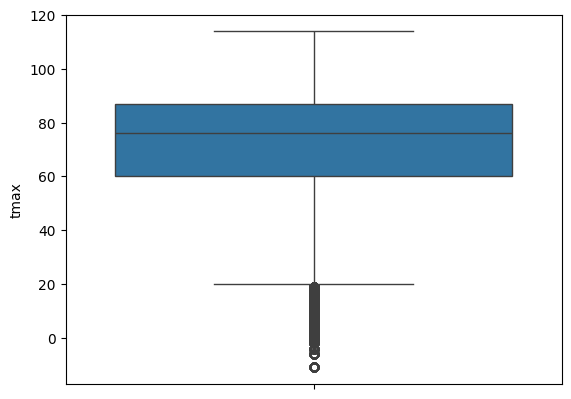

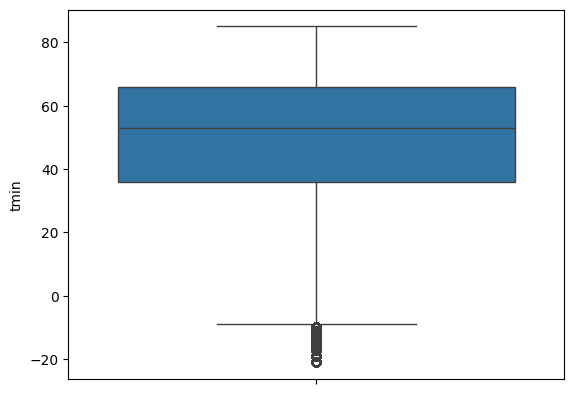

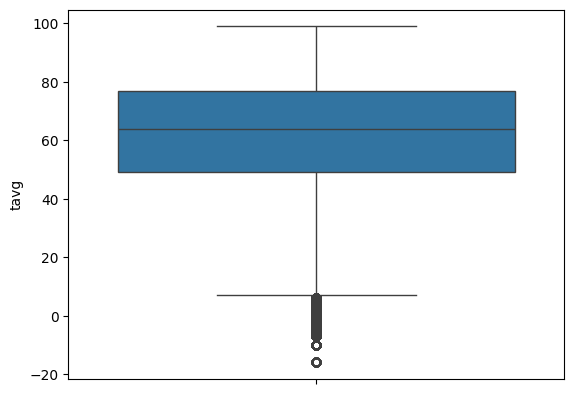

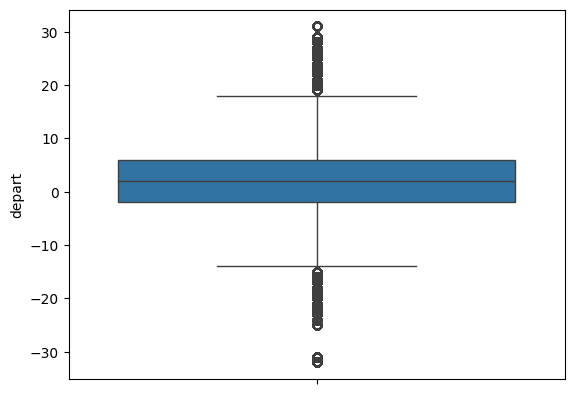

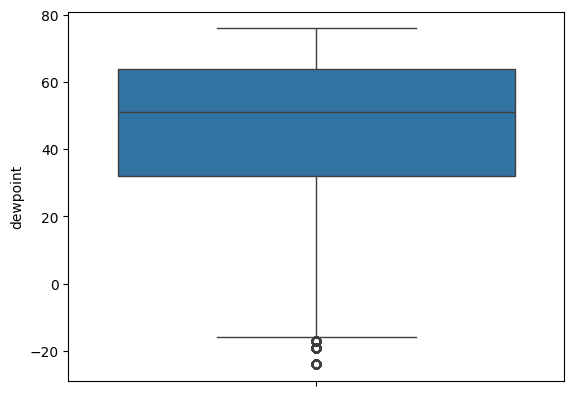

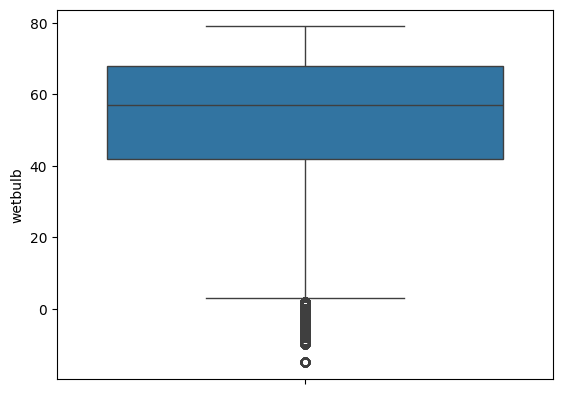

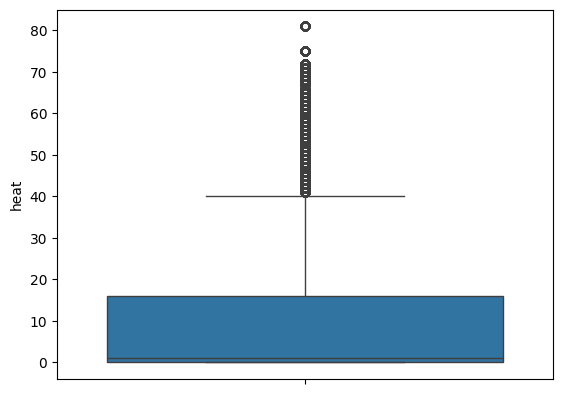

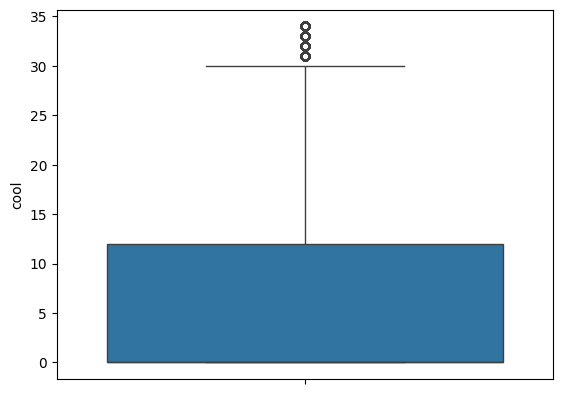

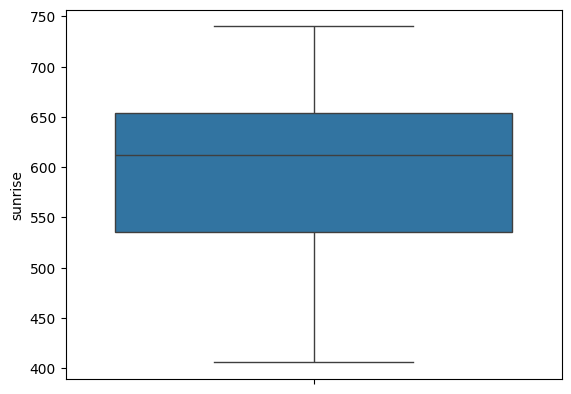

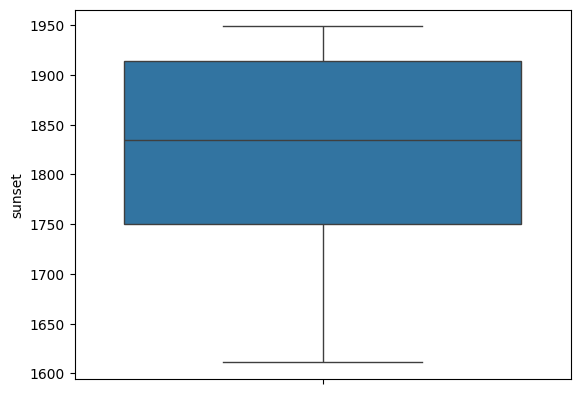

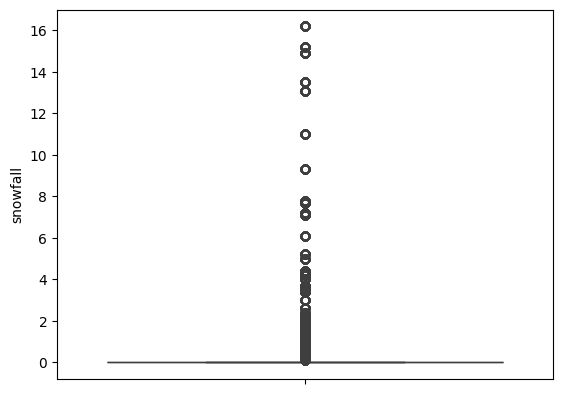

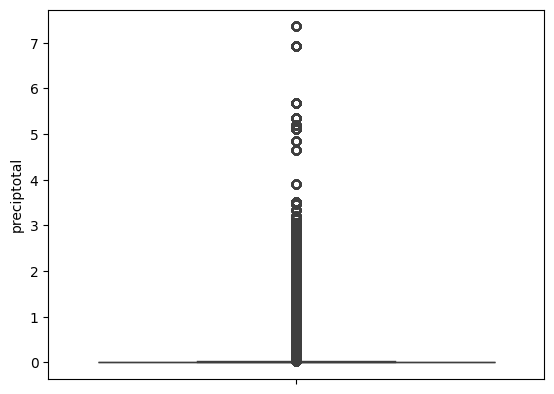

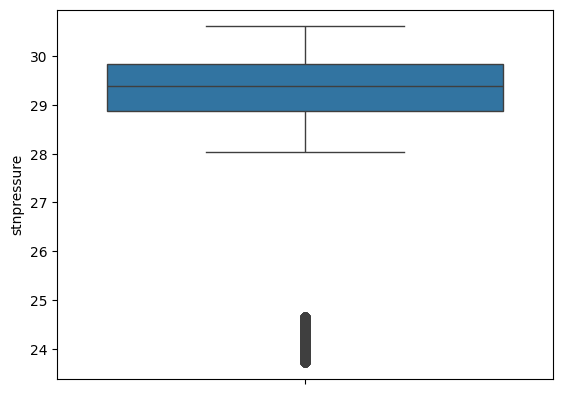

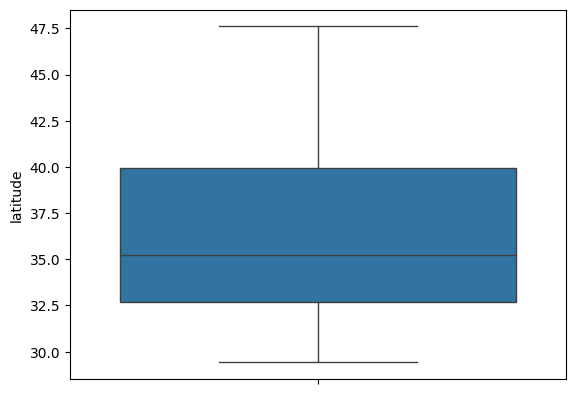

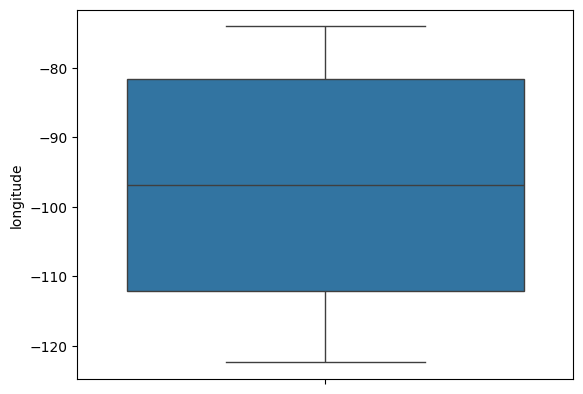

In [59]:
#выявление выбросов
weather_numeric_col = final_merged_data.select_dtypes(include=['float64']).columns.tolist()

for col in weather_numeric_col:
    sns.boxplot(final_merged_data[col])
    plt.show()


In [60]:
# === 5. Очистка погодных данных ===
col_list = ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
            'sunrise', 'sunset', 'snowfall', 'preciptotal', 'stnpressure']

# Создаем общую маску, где изначально все True
mask = pd.Series(True, index=final_merged_data.index)

for col in col_list:
    low_limit = final_merged_data[col].quantile(0.01)
    up_limit = final_merged_data[col].quantile(0.99)
    mask &= (final_merged_data[col] >= low_limit) & (final_merged_data[col] < up_limit)

# Применяем фильтрацию один раз
final_merged_data = final_merged_data[mask]

# Проверяем размер
final_merged_data.shape




(558885, 54)

In [61]:
# === 6. Удаление выбросов по перцентилям ===
final_merged_data = final_merged_data[
    (final_merged_data['units'] >= 0) &
    (final_merged_data['units'] < final_merged_data['units'].quantile(0.99))
]


In [62]:
final_merged_data.shape

(553280, 54)

In [63]:
# === 7. Замена NaN на station-wise среднее ===
for col in weather_numeric_col:
    for station in final_merged_data['station_nbr'].unique():
        station_mask = (final_merged_data['station_nbr'] == station)
        mean_val = final_merged_data.loc[station_mask, col].mean()
        final_merged_data.loc[station_mask, col] = \
            final_merged_data.loc[station_mask, col].fillna(mean_val)



In [64]:
final_merged_data.shape


(553280, 54)

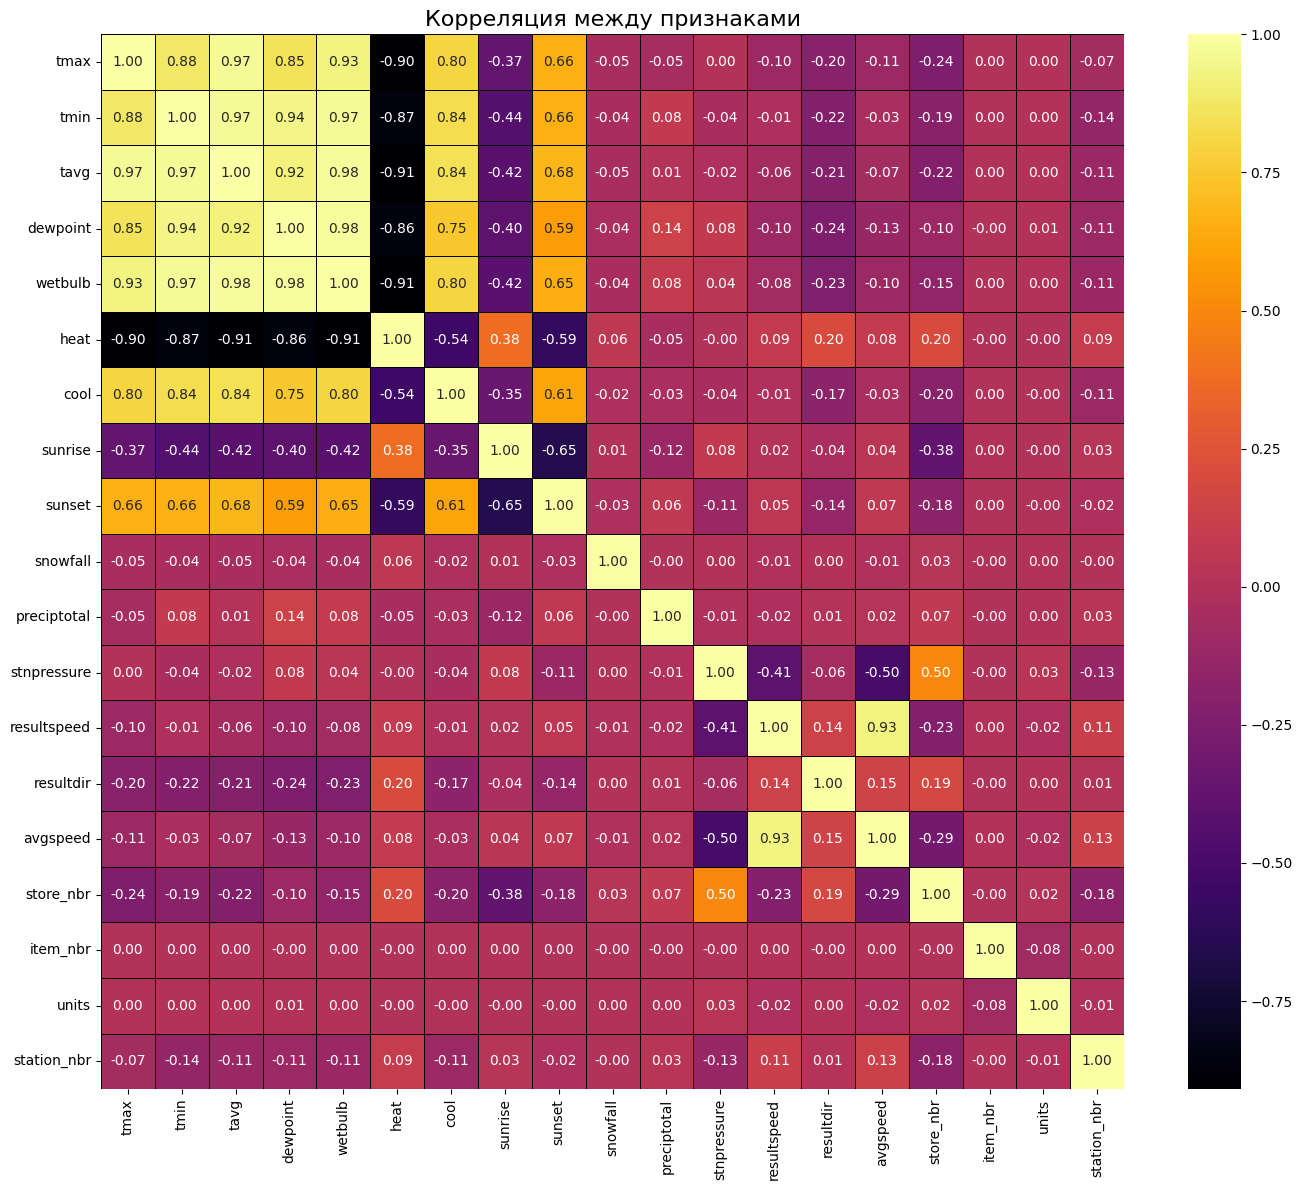

In [65]:
# === 7. Построение корреляционной тепловой карты ===
# Подготовка данных
corr_features = final_merged_data[['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
                                   'sunrise', 'sunset', 'snowfall', 'preciptotal', 'stnpressure',
                                   'resultspeed', 'resultdir', 'avgspeed', 'store_nbr', 'item_nbr',
                                   'units', 'station_nbr']]

# Очистка от текстовых значений
corr_features = corr_features.replace({'M': np.nan, 'T': np.nan, '-': np.nan})
corr_features = corr_features.apply(pd.to_numeric, errors='coerce')

# Корреляция
corr_matrix = corr_features.corr()

# Визуализация
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='inferno', linewidths=0.5, linecolor='black')
plt.title("Корреляция между признаками", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



units практически не зависят напрямую от температуры или осадков, значит нужно:

Либо использовать более сложные взаимосвязи (например, лаги по времени);

Либо включать категориальные признаки (сезон, месяц, выходной, и т.д.);

Либо применять нелинейные модели (деревья, бустинг).

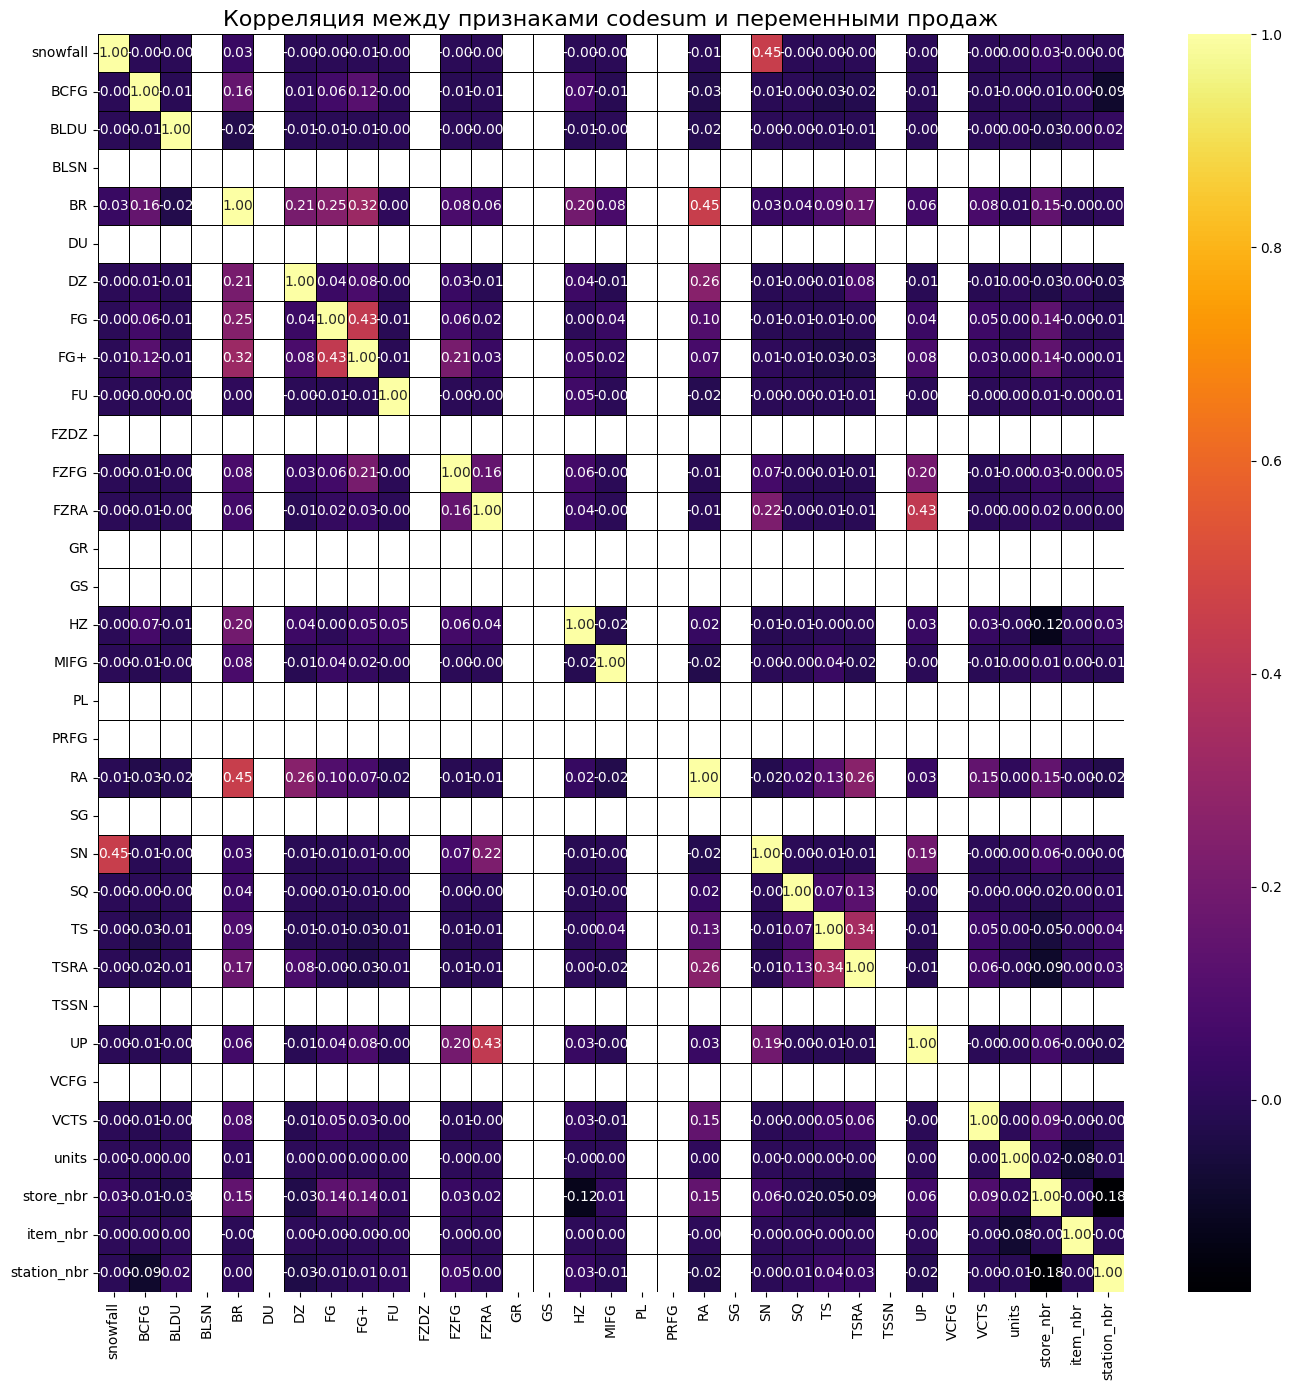

In [66]:
# Выбор признаков
codesum_features = [col for col in final_merged_data.columns if col not in ['date', 'city', 'state', 'latitude', 'longitude']
                    and final_merged_data[col].nunique() <= 2]  # one-hot кодированные признаки
target_features = ['units', 'store_nbr', 'item_nbr', 'station_nbr']

# Объединение всех признаков для корреляции
corr_features = final_merged_data[codesum_features + target_features]

# Убедимся, что все значения числовые
corr_features = corr_features.apply(pd.to_numeric, errors='coerce')

# Построение корреляционной матрицы
corr_matrix = corr_features.corr()

# Построение тепловой карты
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='inferno', linewidths=0.5, linecolor='black')
plt.title("Корреляция между признаками codesum и переменными продаж", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Только FG+ и DU имеют корреляцию ≥ 0.75 — остальные признаки слабосвязаны
codesum признаки не коррелируют с продажами (units)
Признаки codesum хорошо отражают наличие погодных условий, но не объясняют напрямую спрос
Возможно, погодное влияние проявляется через категориальные/временные признаки (день недели, сезон и т.п.), а не напрямую

<ipython-input-67-91eeca0ee953>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_merged_data, x='item_nbr', palette='husl')


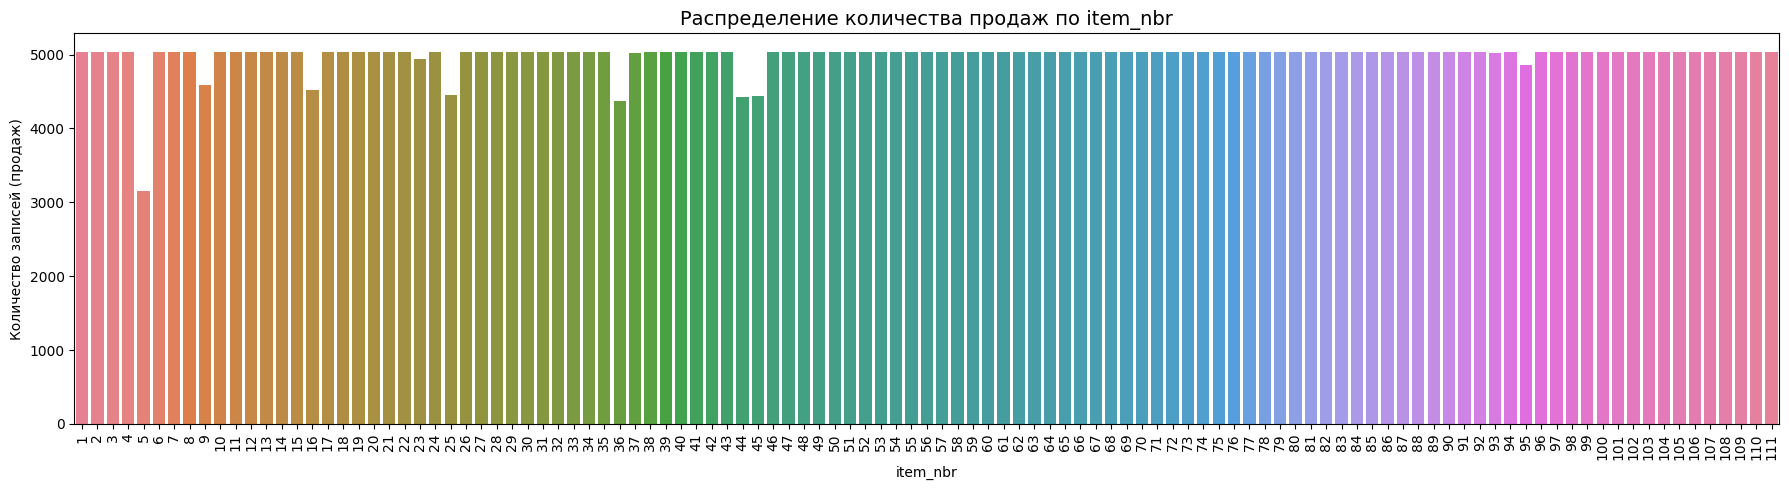

In [67]:
plt.figure(figsize=(18, 5))
sns.countplot(data=final_merged_data, x='item_nbr', palette='husl')
plt.title('Распределение количества продаж по item_nbr', fontsize=14)
plt.xlabel('item_nbr')
plt.ylabel('Количество записей (продаж)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

1. Товары с наибольшим числом продаж:
item_nbr 16 и 23 — явные лидеры. У каждого из них более 1200 записей.

Вероятно, это самые популярные или сезонно востребованные товары.

 2. Умеренно популярные товары:
item_nbr 5, 37, 83, 93 — имеют от 550 до 800 продаж.

Это вторая по значимости группа товаров — возможно, важны в отдельных регионах или сезонах.

 3. Товары с низкими продажами:
Например: item_nbr 15, 25, 36, 45, 84, 88, 104 — имеют менее 100 записей.

Возможно, это:

редко покупаемые товары;

сезонные или специфические продукты;

тестовые позиции;

товары, на которые не было достаточного спроса.

<ipython-input-68-be2b1741a34b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_merged_data, x='store_nbr', palette='husl')


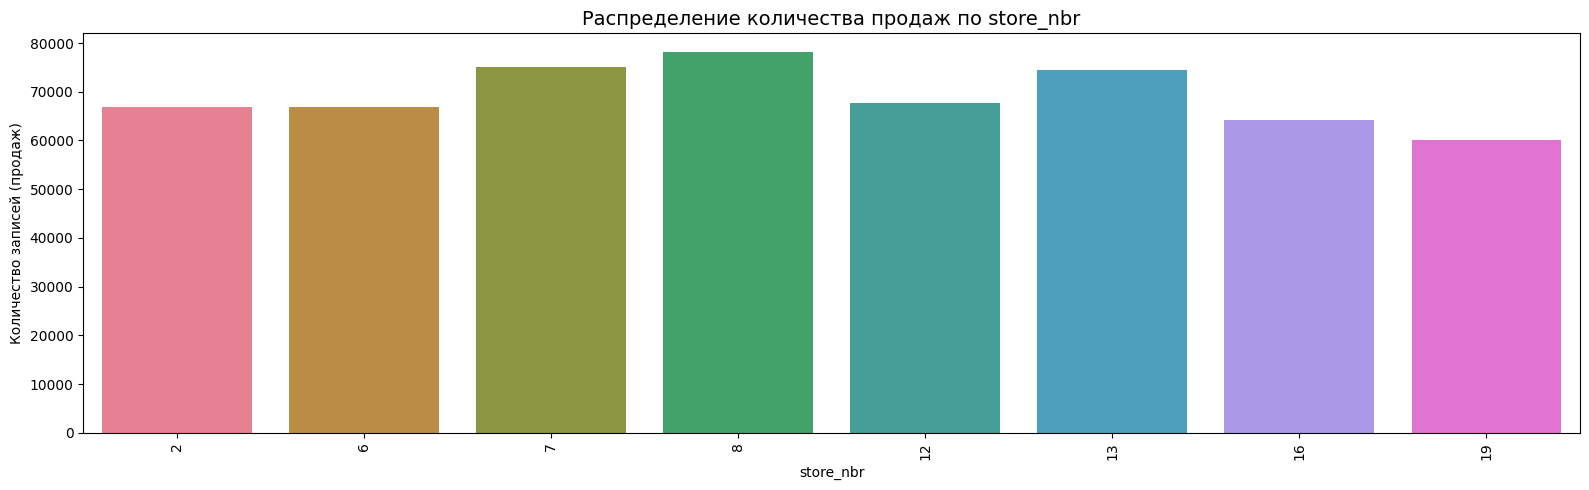

In [68]:
plt.figure(figsize=(16, 5))  # широкая фигура для всех магазинов
sns.countplot(data=final_merged_data, x='store_nbr', palette='husl')

plt.title('Распределение количества продаж по store_nbr', fontsize=14)
plt.xlabel('store_nbr')
plt.ylabel('Количество записей (продаж)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

8, 19	Лидеры продаж	Высокий спрос, возможно центральные локации
7, 12	Устойчивые	Средне-высокий спрос, стабильная активность
16	Потенциальный рост	Может стать лидером при улучшении условий
2, 6, 13	Наименее активные	Требуют анализа: локация, ассортимент, спрос

In [69]:
# Группировка и агрегация по магазину и товару
pivot_table = final_merged_data.pivot_table(
    index=['store_nbr', 'item_nbr'],
    values='units',
    aggfunc='sum'  # можно заменить на 'mean' для среднего объёма продаж
)

# Сортировка по убыванию продаж
pivot_table = pivot_table.sort_values(by='units', ascending=False)

# Вывод результата
pivot_table.head(10)  # или просто display(pivot_table) для всей таблицы


units
store_nbr item_nbr       
7         23        13685
12        37        10091
19        16         8454
16        16         8447
12        16         8440
8         5          8291
          23         7776
19        83         5292
6         9          3925
7         5          3641

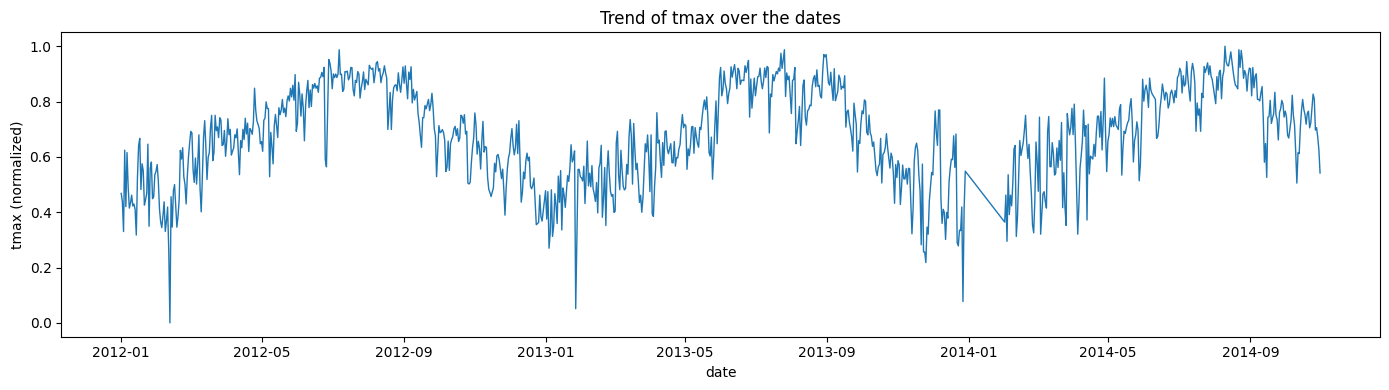

In [70]:
daily_tmax = final_merged_data.groupby('date')['tmax'].mean()

# Нормализация (по желанию — для масштабирования от 0 до 1, как на графике)
daily_tmax_normalized = (daily_tmax - daily_tmax.min()) / (daily_tmax.max() - daily_tmax.min())

# Построение графика
plt.figure(figsize=(14, 4))
plt.plot(daily_tmax_normalized, linewidth=1)
plt.title("Trend of tmax over the dates")
plt.xlabel("date")
plt.ylabel("tmax (normalized)")
plt.tight_layout()
plt.show()

Чётко прослеживаются циклы "зима–лето–зима":

Подъёмы температуры — летние месяцы (примерно май–сентябрь).

Падения температуры — зимние месяцы (декабрь–февраль).

Эти волны повторяются ежегодно и отражают естественный погодный цикл.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


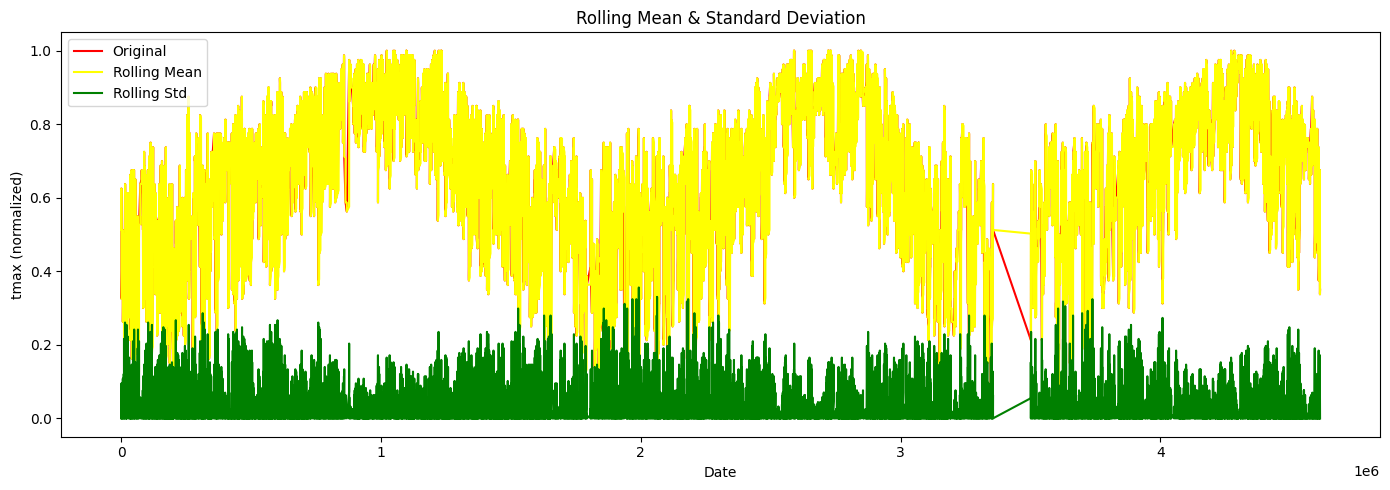

In [71]:
# Расчёт скользящего среднего и стандартного отклонения
df = final_merged_data
ts = (df['tmax'] - df['tmax'].min()) / (df['tmax'].max() - df['tmax'].min())
rolling_mean = ts.rolling(window=30).mean()
rolling_std = ts.rolling(window=30).std()

# Построение графика
plt.figure(figsize=(14, 5))
plt.plot(ts, color='red', label='Original')
plt.plot(rolling_mean, color='yellow', label='Rolling Mean')
plt.plot(rolling_std, color='green', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('tmax (normalized)')
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
#tmax не стационарен

In [73]:
# === 8. Временные признаки, сезоны, выходные, праздники ===

# Извлечение даты, месяца, дня
final_merged_data['year'] = pd.DatetimeIndex(final_merged_data['date']).year
final_merged_data['month'] = pd.DatetimeIndex(final_merged_data['date']).month
final_merged_data['day'] = pd.DatetimeIndex(final_merged_data['date']).day

# Определение сезона по месяцу
final_merged_data.loc[final_merged_data['month'].isin([12, 1, 2]), 'season'] = 'winter'
final_merged_data.loc[final_merged_data['month'].isin([3, 4, 5]), 'season'] = 'spring'
final_merged_data.loc[final_merged_data['month'].isin([6, 7, 8]), 'season'] = 'summer'
final_merged_data.loc[final_merged_data['month'].isin([9, 10, 11]), 'season'] = 'fall'

# Отметка выходных (0 — будний день, 1 — выходной)
final_merged_data['weekend'] = (pd.DatetimeIndex(final_merged_data['date']).dayofweek >= 5).astype(int)


# Отметка праздничных дней (на основе календаря США)
us_holidays = holidays.US()
final_merged_data['holidays'] = final_merged_data['date'].apply(lambda x: 1 if x in us_holidays else 0)

# Вывод количества записей по сезонам
print(final_merged_data['season'].value_counts())


season
spring    158165
fall      153596
summer    134438
winter    107081
Name: count, dtype: int64


Весна доминирует в датасете: ~32% от всех наблюдений.
Это может быть связано с тем, что в этот период:

Больше данных о продажах;

Или в этот сезон активнее велась запись (например, в рамках акций/сезонных закупок).

Зима представлена меньше всего. Это может повлиять на обучение модели:

Возможна смещённость в предсказаниях по зимнему периоду;

Важно учесть, если модель делает сезонные прогнозы.

In [74]:

# Извлечение месяца
final_merged_data['month'] = final_merged_data['date'].dt.month

# Определение сезона на основе месяца
final_merged_data.loc[final_merged_data['month'].isin([6, 7, 8]), 'season'] = 'summer'
final_merged_data.loc[final_merged_data['month'].isin([9, 10, 11]), 'season'] = 'fall'
final_merged_data.loc[final_merged_data['month'].isin([12, 1, 2]), 'season'] = 'winter'
final_merged_data.loc[final_merged_data['month'].isin([3, 4, 5]), 'season'] = 'spring'

# Признак "holiday": 1 если дата является официальным праздником США, иначе 0
us_holidays = holidays.US()
final_merged_data['holidays'] = final_merged_data['date'].apply(lambda x: 1 if x in us_holidays else 0)

# Посчитаем количество записей по праздникам и будням
print(final_merged_data['holidays'].value_counts())

holidays
0    538874
1     14406
Name: count, dtype: int64


In [75]:
# Извлечение года, месяца и дня
final_merged_data['year'] = final_merged_data['date'].dt.year
final_merged_data['month'] = final_merged_data['date'].dt.month
final_merged_data['day'] = final_merged_data['date'].dt.day

# Признак выходного дня: 1 — выходной (суббота/воскресенье), 0 — будний день
final_merged_data['weekend'] = final_merged_data['date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# Определение сезона на основе месяца
final_merged_data.loc[final_merged_data['month'].isin([12, 1, 2]), 'season'] = 'winter'
final_merged_data.loc[final_merged_data['month'].isin([3, 4, 5]), 'season'] = 'spring'
final_merged_data.loc[final_merged_data['month'].isin([6, 7, 8]), 'season'] = 'summer'
final_merged_data.loc[final_merged_data['month'].isin([9, 10, 11]), 'season'] = 'fall'




In [76]:
print(final_merged_data[['year', 'month', 'day', 'season', 'weekend', 'holidays']].head())


     year  month  day  season  weekend  holidays
666  2012      1    1  winter        1         1
667  2012      1    1  winter        1         1
668  2012      1    1  winter        1         1
669  2012      1    1  winter        1         1
671  2012      1    1  winter        1         1


In [77]:
print(final_merged_data['season'].value_counts())


season
spring    158165
fall      153596
summer    134438
winter    107081
Name: count, dtype: int64


In [78]:
# Шаг 1. Создание one-hot признаков для 'season'
df_season = pd.get_dummies(final_merged_data['season'], prefix='is')

# Шаг 2. Объединение с основным датафреймом
final_merged_data = final_merged_data.join(df_season)

# Шаг 3. Удаление оригинального текстового признака
final_merged_data = final_merged_data.drop(['season'], axis=1)

# Шаг 4. Проверка результата
print(final_merged_data.shape)
final_merged_data.head()



(553280, 63)


,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,longitude,year,month,day,weekend,holidays,is_fall,is_spring,is_summer,is_winter
666,2012-01-01,7,1,0,6,63.0,34.0,49.0,0.0,31.0,...,-98.4936,2012,1,1,1,1,False,False,False,True
667,2012-01-01,7,2,0,6,63.0,34.0,49.0,0.0,31.0,...,-98.4936,2012,1,1,1,1,False,False,False,True
668,2012-01-01,7,3,0,6,63.0,34.0,49.0,0.0,31.0,...,-98.4936,2012,1,1,1,1,False,False,False,True
669,2012-01-01,7,4,0,6,63.0,34.0,49.0,0.0,31.0,...,-98.4936,2012,1,1,1,1,False,False,False,True
671,2012-01-01,7,6,0,6,63.0,34.0,49.0,0.0,31.0,...,-98.4936,2012,1,1,1,1,False,False,False,True


In [79]:
# Создание признака "sale": 1 если units > 0, иначе 0
final_merged_data["sale"] = np.where(final_merged_data['units'] > 0, 1, 0)

# Проверка распределения
print(final_merged_data['sale'].value_counts())





sale
0    544872
1      8408
Name: count, dtype: int64


In [80]:
# --------- Разделение признаков и целевых переменных ---------
X = final_merged_data.drop(['units', 'sale'], axis=1)
y_class = final_merged_data['sale']

Удалён datetime-признак: date


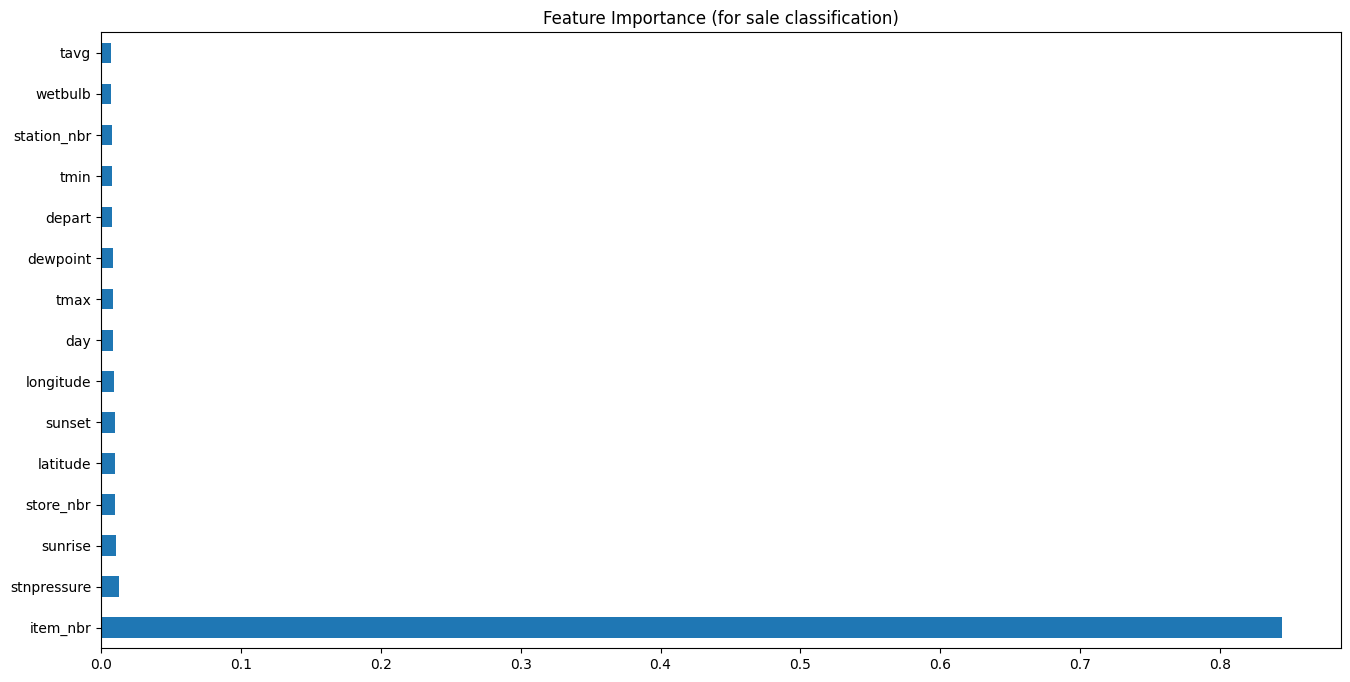

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = final_merged_data.drop(['units', 'sale'], axis=1)
y_class = final_merged_data['sale']

# Только удаление date
for col in X.columns:
    if np.issubdtype(X[col].dtype, np.datetime64):
        print(f"Удалён datetime-признак: {col}")
        X = X.drop(columns=[col])

#Берем только числовые признаки
X = X.select_dtypes(include=['number'])

# --------- Визуализация Feature Importance до фильтрации ---------
X_train_full, _, y_train_full, _ = train_test_split(X, y_class, test_size=0.3, random_state=42)
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_full, y_train_full)

clf_feat_imp = pd.Series(clf_rf.feature_importances_, index=X_train_full.columns)
plt.figure(figsize=(16, 8))
clf_feat_imp.nlargest(15).plot(kind='barh')
plt.title("Feature Importance (for sale classification)")
plt.show()



In [82]:
X['item_nbr'] = X['item_nbr'].astype('category').cat.codes


In [83]:
# --------- Классификация: Logistic Regression ---------
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.3, random_state=42)
lr = LogisticRegression(max_iter=1000, class_weight='balanced')  # добавлено class_weight
params = {
    'C': [10, 1, 0.1],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs']
}
rs = RandomizedSearchCV(lr, params, n_iter=6, scoring='f1', cv=5, n_jobs=-1)
rs.fit(X_train, y_train)

y_train_pred = rs.predict(X_train)
y_test_pred = rs.predict(X_test)

In [84]:
# --------- Метрики классификации ---------
from sklearn import metrics

print("F1 Score and ROC-AUC for y_train")
print("ROC AUC:", metrics.roc_auc_score(y_train, y_train_pred))
print("F1 Score:", metrics.f1_score(y_train, y_train_pred))

print("\nF1 Score and ROC-AUC for y_test")
print("ROC AUC:", metrics.roc_auc_score(y_test, y_test_pred))
print("F1 Score:", metrics.f1_score(y_test, y_test_pred))

F1 Score and ROC-AUC for y_train
ROC AUC: 0.6326200383721039
F1 Score: 0.04881435065732891

F1 Score and ROC-AUC for y_test
ROC AUC: 0.626345234983879
F1 Score: 0.045812229948207286


<ipython-input-85-e38e88beb852>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


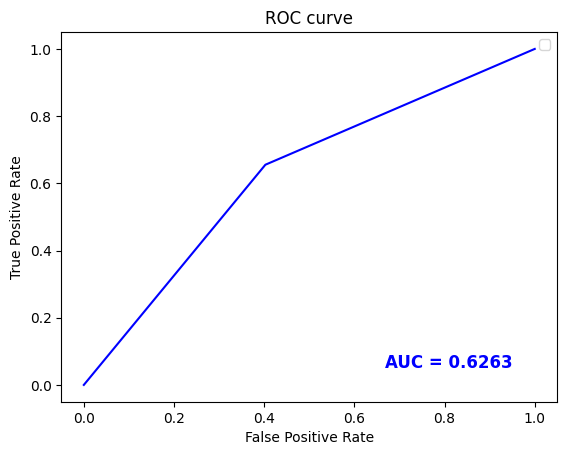

In [85]:
# --------- ROC-кривая ---------
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_pred)
auc = metrics.roc_auc_score(y_test, y_test_pred)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.legend(loc='best')
plt.show()

In [86]:
# --------- Отбор записей с sale == 1 ---------
X_train_reg = X_train[y_train_pred == 1]
y_train_reg = final_merged_data.loc[X_train_reg.index, 'units']
X_test_reg = X_test[y_test_pred == 1]
y_test_reg = final_merged_data.loc[X_test_reg.index, 'units']

In [87]:
# --------- Модели регрессии + RandomizedSearchCV ---------
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

model_params = {

    'lgbm': {
        'model': LGBMRegressor(),
        'params': {
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 200, 500],
            'num_leaves': [31, 50],
            'min_child_samples': [20, 40]
        }
    }
}

scores = []

for model_name, mp in model_params.items():
    rscv = RandomizedSearchCV(mp['model'], mp['params'], n_jobs=-1, error_score='raise', cv=5)
    rscv.fit(X_train_reg, y_train_reg)
    preds = rscv.predict(X_test_reg)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_reg, preds))
    scores.append({
        'Model Name': model_name.upper(),
        'Root mean squared error (RMSE)': rmse
    })


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 156815, number of used features: 41
[LightGBM] [Info] Start training from score 0.352167


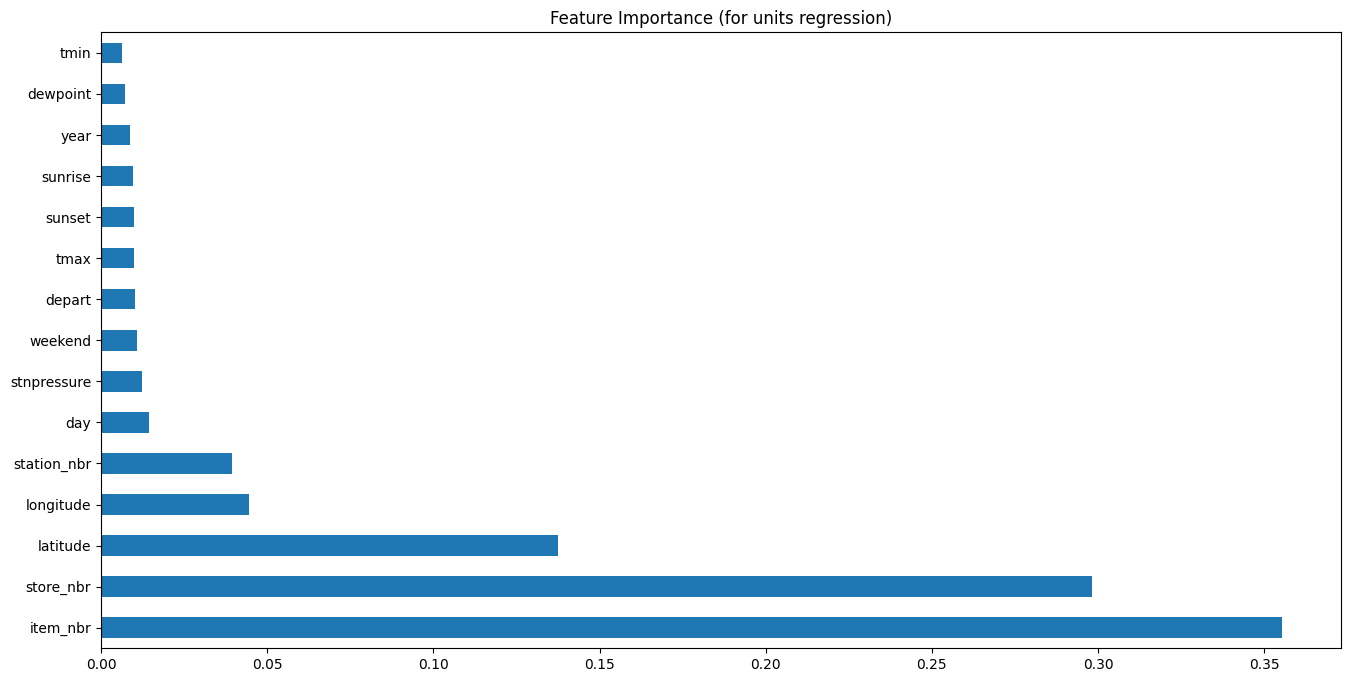

In [88]:
# --------- Feature Importance для регрессии (после sale==1) ---------
rfr = RandomForestRegressor()
rfr.fit(X_train_reg, y_train_reg)
feat_importances = pd.Series(rfr.feature_importances_, index=X_train_reg.columns)

plt.figure(figsize=(16, 8))
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Feature Importance (for units regression)")
plt.show()

In [89]:
# --------- Сводная таблица по RMSE ---------
result_df = pd.DataFrame(scores)
print(result_df)

  Model Name  Root mean squared error (RMSE)
0       LGBM                        0.838642
